In [27]:
# Numerical analysis
import numpy as np
import jax.numpy as jnp
from jax import random

# Bayesian inference
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
import arviz as az

# Utils
from random import randrange
from sklearn.metrics import mean_squared_error

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Set pseudo random number key
prng_key = random.PRNGKey(0)

<h1> Overview </h1>

We will compare how hyperprior choice $\tau$ affects performance of the horseshoe prior by replicating an experiment done by Piironen and Vehtari in "Sparsity information and regularization in the horseshoe and other shrinkage priors".

<h1> Generating Data </h1>

$$y_i \sim \beta_i + \epsilon_i$$
$$\epsilon_i \sim N(0, \sigma^2), \;\; i = 1, ..., 400$$
Similarly to Piironen's toy example, We generate $100$ data realizations. Our true parameter vector $\beta^*$ has length $D=400$ and $p^*=20$ non-zero entries with some value $A \in$ $\{1, 2, ..., 10\}$. The total number of observations per realization is $n=400$.

In [28]:
def generate_data(dim, pstar, a, sigma, nrep):
  """
  Parameters:
    int dim: The dimension of the dataset
    int pstar: The number of true non-zero signals
    real a: The magnitude of true non-zero signals
    real sigma: Standard deviation of the noise
    nrep: The number of replications
  """
  data = np.zeros((nrep, dim))                                # Initialise
  data[:,0:(pstar-1)] = data[:,0:(pstar-1)] + a               # Add signal
  data = data + np.random.normal(0, sigma, size=(nrep, dim))  # Add noise
  return data

test = generate_data(400, 20, 10, 0.1, 100)

<h2> Defining the Model </h2>

Horseshoe prior:

$$\begin{align*} y_i &\sim N(\beta_i, \sigma^2) \quad \text{for } i = 1,2,\ldots, n \\
\beta_i &\sim N(0, \tau^2 \lambda_i^2) \\
\lambda_i &\sim C^+(0, 1)
\end{align*}$$




We will compare two different hyperpriors for $\tau$: 

$\tau \sim C^+(0, 1)$ and $\tau = \tau_0 = \frac{p^*}{D-p^*}\sigma$.

In [29]:
def hs_model(y=None, sigma=1):
        '''
        Parameters:
           array y: dependent variable
           int sigma: stdev of y
        '''
        D = y.size
        hc_lambdas = numpyro.sample("lambdas", dist.HalfCauchy(jnp.ones(D)))
        hc_tau = numpyro.sample('tau', dist.HalfCauchy(1))
        # slightly different parametrization for efficiency
        hc_unscaled_betas = numpyro.sample("unscaled_betas", dist.Normal(0, jnp.ones(D)))
        hc_scaled_betas = numpyro.deterministic("betas", hc_tau*hc_lambdas*hc_unscaled_betas)

        hc_kappas = numpyro.deterministic("kappas", 1 / (1 + n * hc_tau**2 * hc_lambdas**2))
        numpyro.sample('y', dist.Normal(hc_scaled_betas, sigma), obs=y)

def rhs_fixed_model(y=None, sigma=1):
        '''
        Parameters:
           array y: dependent variable
           int sigma: stdev of y
        '''
        D = y.size
        p_star = 20
        t0_lambdas = numpyro.sample("lambdas", dist.HalfCauchy(jnp.ones(D)))
        t0_tau = (p_star / (D-p_star)) * sigma
        
        # slightly different parametrization for efficiency
        t0_unscaled_betas = numpyro.sample("unscaled_betas", dist.Normal(0, jnp.ones(D)))
        t0_scaled_betas = numpyro.deterministic("betas", t0_tau*t0_lambdas*t0_unscaled_betas)

        kappas = numpyro.deterministic("kappas", 1 / (1 + n * t0_tau**2 * t0_lambdas**2))
        numpyro.sample('y', dist.Normal(t0_scaled_betas, sigma), obs=y)

In [30]:
def run_mcmc(model, prng_key, y, **kwargs):
    nuts = NUTS(model)
    mcmc = MCMC(nuts, num_warmup=500, num_samples=1000)
    mcmc.run(prng_key, y=y, **kwargs)
    return mcmc

In [31]:
def halfcauchy(all_data):
    hc_beta_samples = {}
    hc_kappa_samples = []
    hc_mean_sq_errors = [0]*11

    for A, (y, beta_star) in all_data.items():
        hc = run_mcmc(hs_model, prng_key, y)
        hc_samples = hc.get_samples()
        estimated_betas_halfcauchy = hc_samples['betas'].mean(axis=0)
        hc_mean_sq_errors[A] = jnp.mean((estimated_betas_halfcauchy-beta_star)**2)
        hc_beta_samples[A] = estimated_betas_halfcauchy 
        hc_kappa_samples.extend(hc_samples['kappas'])
    return hc_mean_sq_errors, hc_kappa_samples, hc_beta_samples

In [32]:
def tau0(all_data):
    t0_beta_samples = {}
    t0_kappa_samples = []
    t0_mean_sq_errors = [0]*11

    for A, (y, beta_star) in all_data.items():
        t0 = run_mcmc(rhs_fixed_model, prng_key, y)
        t0_samples = t0.get_samples()
        t0_estimated_betas = t0_samples['betas'].mean(axis=0)
        t0_mean_sq_errors[A] = jnp.mean((t0_estimated_betas-beta_star)**2)
        t0_beta_samples[A] = t0_estimated_betas
        t0_kappa_samples.extend(t0_samples['kappas'])
    return t0_mean_sq_errors, t0_kappa_samples, t0_beta_samples

<h1> Run and Evaluate MCMC </h1>

In [33]:
# Parameters
n_realizations = 1
n = 400 # number of observations, length of beta_star 
D = n 
p_star = 20 # number of non-zero predictors
sigma = 1 # noise parameter

In [34]:
hc_all_mse_values = []
t0_all_mse_values = []
all_kappas = []
hc_all_betas = [[]]*11
t0_all_betas = [[]]*11

for _ in range(n_realizations):
    all_data = {}
    A_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    smaller_A_values = [4, 6]
    for A in A_values:
        all_data[A] = get_data(A) #all_data[A] = (y, beta_stars) for that A

    hc_mean_sq_errors, hc_kappas, hc_betas = halfcauchy(all_data)
    hc_all_mse_values.append(hc_mean_sq_errors)
    all_kappas.extend(hc_kappas)

    t0_mean_sq_errors, t0_kappas, t0_betas = tau0(all_data)
    t0_all_mse_values.append(t0_mean_sq_errors)
    all_kappas.extend(t0_kappas)
    
    for A in A_values:
        hc_all_betas[A].append(hc_betas[A])
        t0_all_betas[A].append(t0_betas[A])

hc_all_mse_values = np.array(hc_all_mse_values)
hc_mean_mse_values = np.mean(hc_all_mse_values, axis=0)
t0_all_mse_values = np.array(t0_all_mse_values)
t0_mean_mse_values = np.mean(t0_all_mse_values, axis=0)

hc_mean_betas = [0]*11
t0_mean_betas = [0]*11

for A in A_values:
    hc_mean_betas[A] = np.mean(np.array(hc_all_betas[A]), axis=0)
    t0_mean_betas[A] = np.mean(np.array(t0_all_betas[A]), axis=0)

sample: 100%|██████████| 1500/1500 [00:02<00:00, 646.21it/s, 127 steps of size 2.80e-02. acc. prob=0.86] 


The <a href=https://mc-stan.org/docs/2_21/reference-manual/effective-sample-size-section.html>estimated effective sample size (ESS)</a> measures how much information is lost in MCMC due to correlation between different samples.

The <a href=https://arxiv.org/abs/1812.09384>Gelman-Rubin statistic</a> ($\hat{R}$) examines how well the chains have mixed. Common thresholds used include $1.01$, $1.05$, and $1.1$.

In [35]:
# for mcmc in all_mcmc_runs[:5]:
#     print(az.ess(mcmc))
#     print(az.rhat(mcmc))

<h1> Results </h1>

[Text(0.5, 0, 'Entry $i$')]

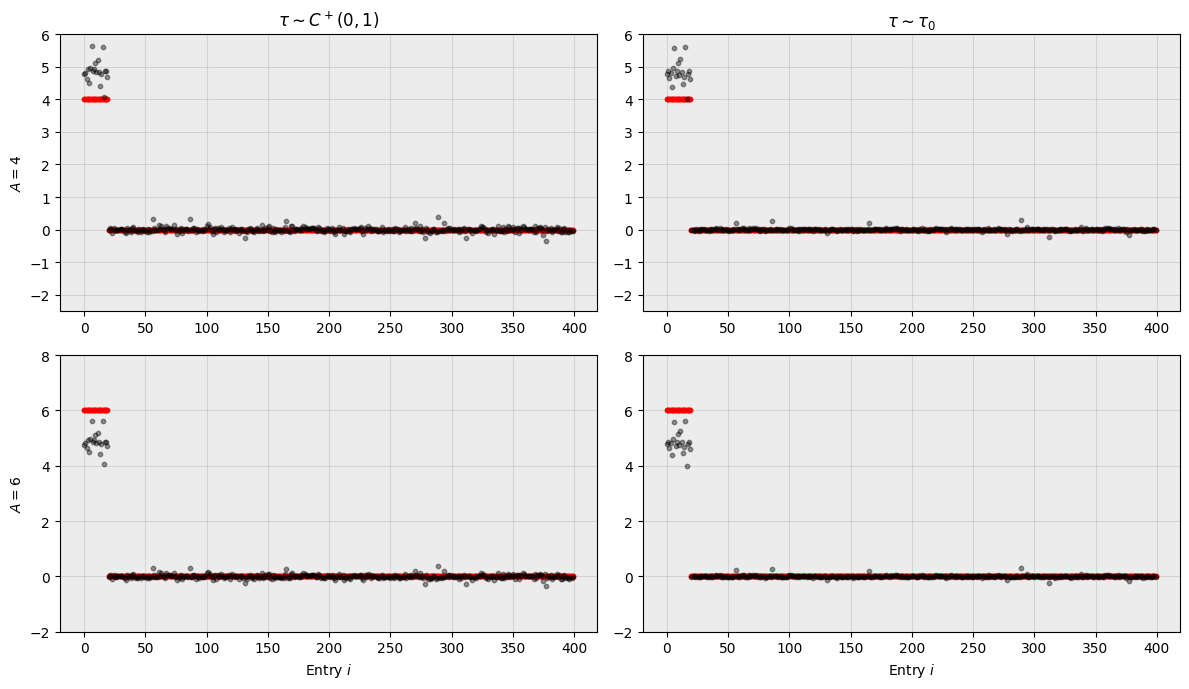

In [36]:
def plot_posterior_betas(beta_star, estimated_betas, ax):
    ax.scatter(range(D), beta_star, color='red', s=10) # plot actual betas
    ax.scatter(range(D), estimated_betas, color='black', s=10, alpha=0.4) # plot estimated betas
    # ax.scatter(range(len(y[i])), y[i], s=10, alpha=0.2, color='grey', marker='+') # plot y values


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 7), layout="tight")
for ax in [ax1, ax2, ax3, ax4]: 
    ax.set_facecolor("#ECECEC") # set graph background color to grey
    ax.grid(visible=True, color="black", alpha=0.1) # add grid lines

# resetting y-axis range so that the graphs line up
ax4.set_ylim([-2, 8]) 
ax3.set_ylim([-2, 8])
ax2.set_ylim([-2.5, 6]) 
ax1.set_ylim([-2.5, 6])

beta_star_4 = np.zeros(n)
beta_star_4[range(20)] = 4
beta_star_6 = np.zeros(n)
beta_star_6[range(20)] = 6
plot_posterior_betas(beta_star_4, hc_mean_betas[4], ax1)
plot_posterior_betas(beta_star_4, t0_mean_betas[4], ax2)
plot_posterior_betas(beta_star_6, hc_mean_betas[6], ax3)
plot_posterior_betas(beta_star_6, t0_mean_betas[6], ax4)

# add labels to graph
ax1.set_title(r'$\tau \sim C^+(0, 1)$')
ax2.set_title(r'$\tau \sim \tau_0$')
ax1.set(ylabel=r'$A=4$')
ax3.set(ylabel=r'$A=6$', xlabel=r'Entry $i$')
ax4.set(xlabel=r'Entry $i$')


(0.0, 0.3)

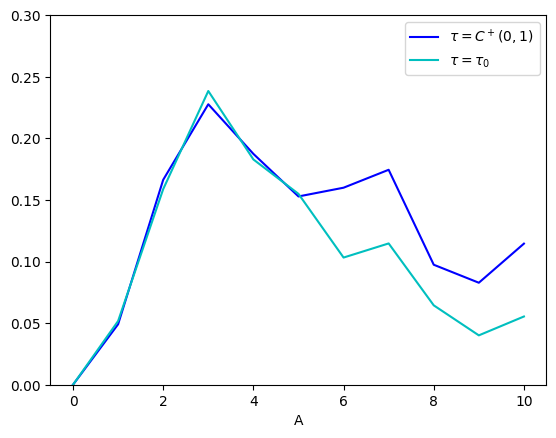

In [41]:
plt.plot(range(len(hc_mean_mse_values)), hc_mean_mse_values, "b", label=r'$\tau \sim C^+(0, 1)$')
plt.plot(range(len(t0_mean_mse_values)), t0_mean_mse_values, "c", label=r'$\tau \sim \tau_0$')
ax = plt.gca()
plt.legend()
plt.xlabel("A")
ax.set_ylim([0, 0.3])

Text(0.5, 0, '\\kappa')

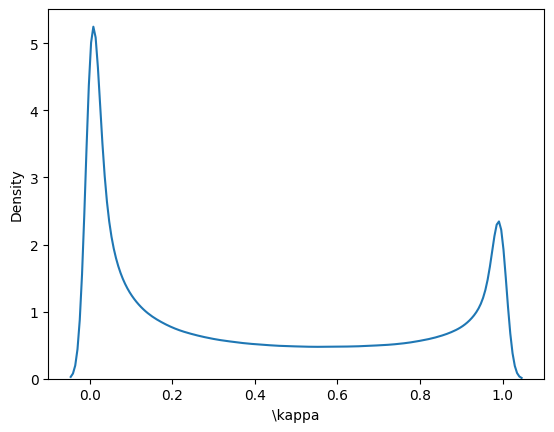

In [42]:
all_kappas = np.ndarray.flatten(np.array(all_kappas))
sns.kdeplot(all_kappas, legend=None)